# 🏦 Bank Customer Churn Prediction

### **Business Context**
It costs much more to acquire a new customer than to retain an existing one. For banks, identifying which customers are likely to leave (Churn) is critical.

### **Goal**
Build a Machine Learning model to predict if a customer will exit the bank based on their Credit Score, Balance, Age, and other factors. We will focus on **Recall** (catching as many churners as possible) rather than just accuracy.

### **Strategy**
1. **EDA:** Analyze which factors (Age, Geography, Products) drive churn.
2. **Preprocessing:** Fix the "Geography Trap" using One-Hot Encoding.
3. **Handling Imbalance:** The dataset is imbalanced (80% Stay, 20% Leave). We will use `scale_pos_weight` to force the model to pay attention to churners.
4. **Modeling:** Train an **XGBoost Classifier**.
5. **Interpretation:** Use Feature Importance to tell the bank *why* customers are leaving.

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

In [64]:
df=pd.read_csv("./Churn_Modelling.csv")

In [65]:
df.shape

(10000, 14)

In [66]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Surname : The surname of the customer
CreditScore : The credit score of the customer
Geography : The country of the customer(Germany/France/Spain)
Gender : The gender of the customer (Female/Male)
Age : The age of the customer
Tenure : The customer's number of years in the in the bank
Balance : The customer's account balance
NumOfProducts : The number of bank products that the customer uses
HasCrCard : Does the customer has a card? (0=No, 1=Yes)
IsActiveMember : Does the customer has an active mebership (0=No, 1=Yes)
EstimatedSalary : The estimated salary of the customer
Exited : Churned or not? (0=No, 1=Yes)

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [68]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [69]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


### **2. Feature Engineering & Encoding**
**The Problem:** Computers cannot understand text like "France" or "Male".
**The Solution:**
* **Gender:** We map Female/Male to 0/1.
* **Geography:** We use **One-Hot Encoding** (`pd.get_dummies`). 
    * *Note:* We avoid Label Encoding (0, 1, 2) here because it would confuse the model into thinking Spain (2) is "greater than" France (0).

### **3. Correlation Analysis**
We check how features relate to the target (`Exited`).
* **Positive Correlation:** As this feature increases, Churn increases (e.g., Age).
* **Negative Correlation:** As this feature increases, Churn decreases (e.g., IsActiveMember).

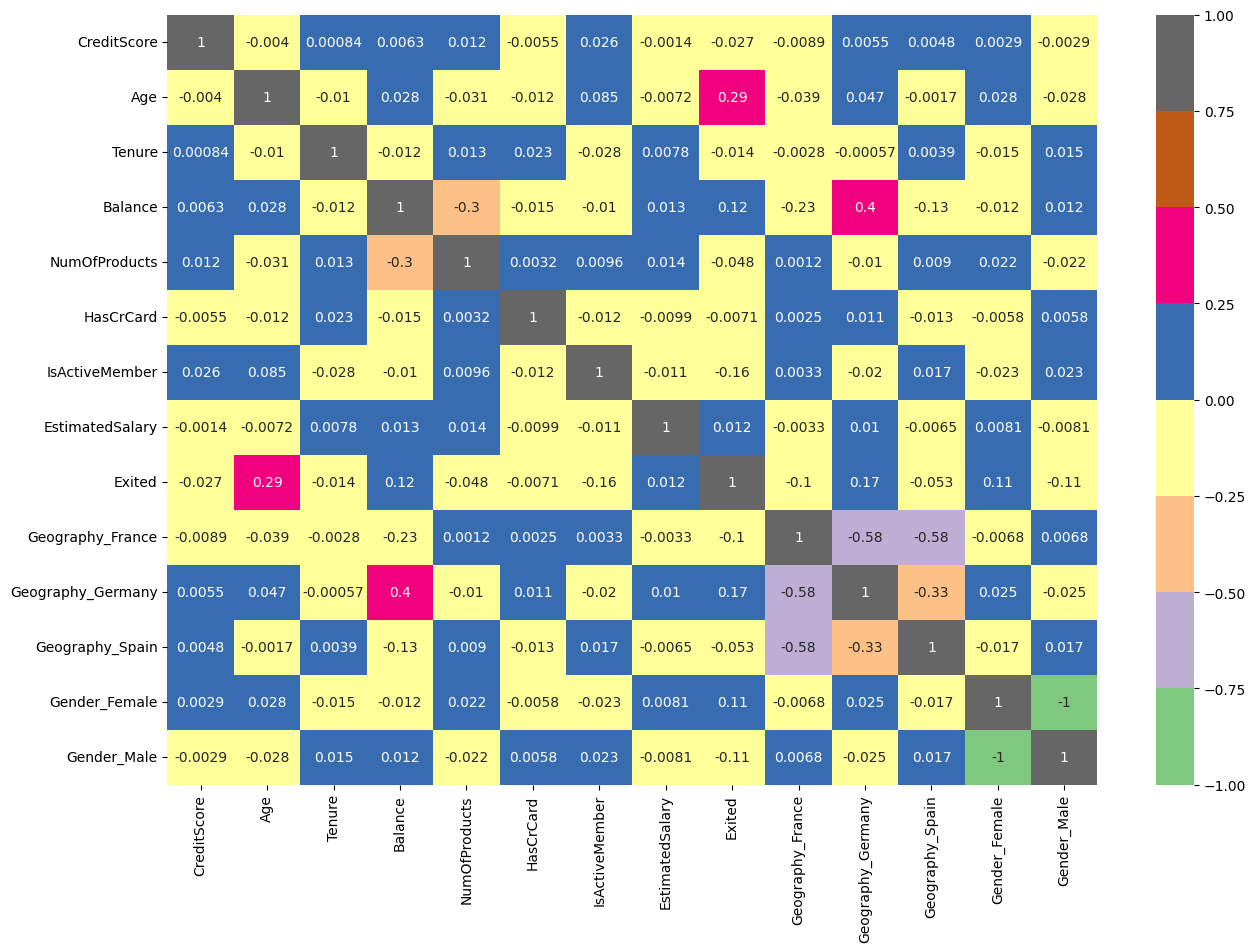

In [70]:
# 1. Drop the columns we don't need
df_clean = df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], axis=1)

# 2. One-Hot Encoding
df_clean = pd.get_dummies(df_clean, columns=['Geography', 'Gender'], drop_first=False, dtype=int)

# 3. Calculate Correlation AND SAVE IT to 'corr'
corr = df_clean.corr()  # <--- This is the line you were missing!

# 4. Plot
plt.figure(figsize=(15,10))
sns.heatmap(corr, annot=True, cmap="Accent")
plt.show()

In [71]:
features=corr['Exited'].sort_values(ascending=False)[1:]

In [72]:
features.index

Index(['Age', 'Geography_Germany', 'Balance', 'Gender_Female',
       'EstimatedSalary', 'HasCrCard', 'Tenure', 'CreditScore',
       'NumOfProducts', 'Geography_Spain', 'Geography_France', 'Gender_Male',
       'IsActiveMember'],
      dtype='object')

In [73]:
features.values

array([ 0.28532304,  0.17348787,  0.11853277,  0.10651249,  0.01209686,
       -0.00713777, -0.01400061, -0.02709354, -0.04781986, -0.05266676,
       -0.10495516, -0.10651249, -0.15612828])

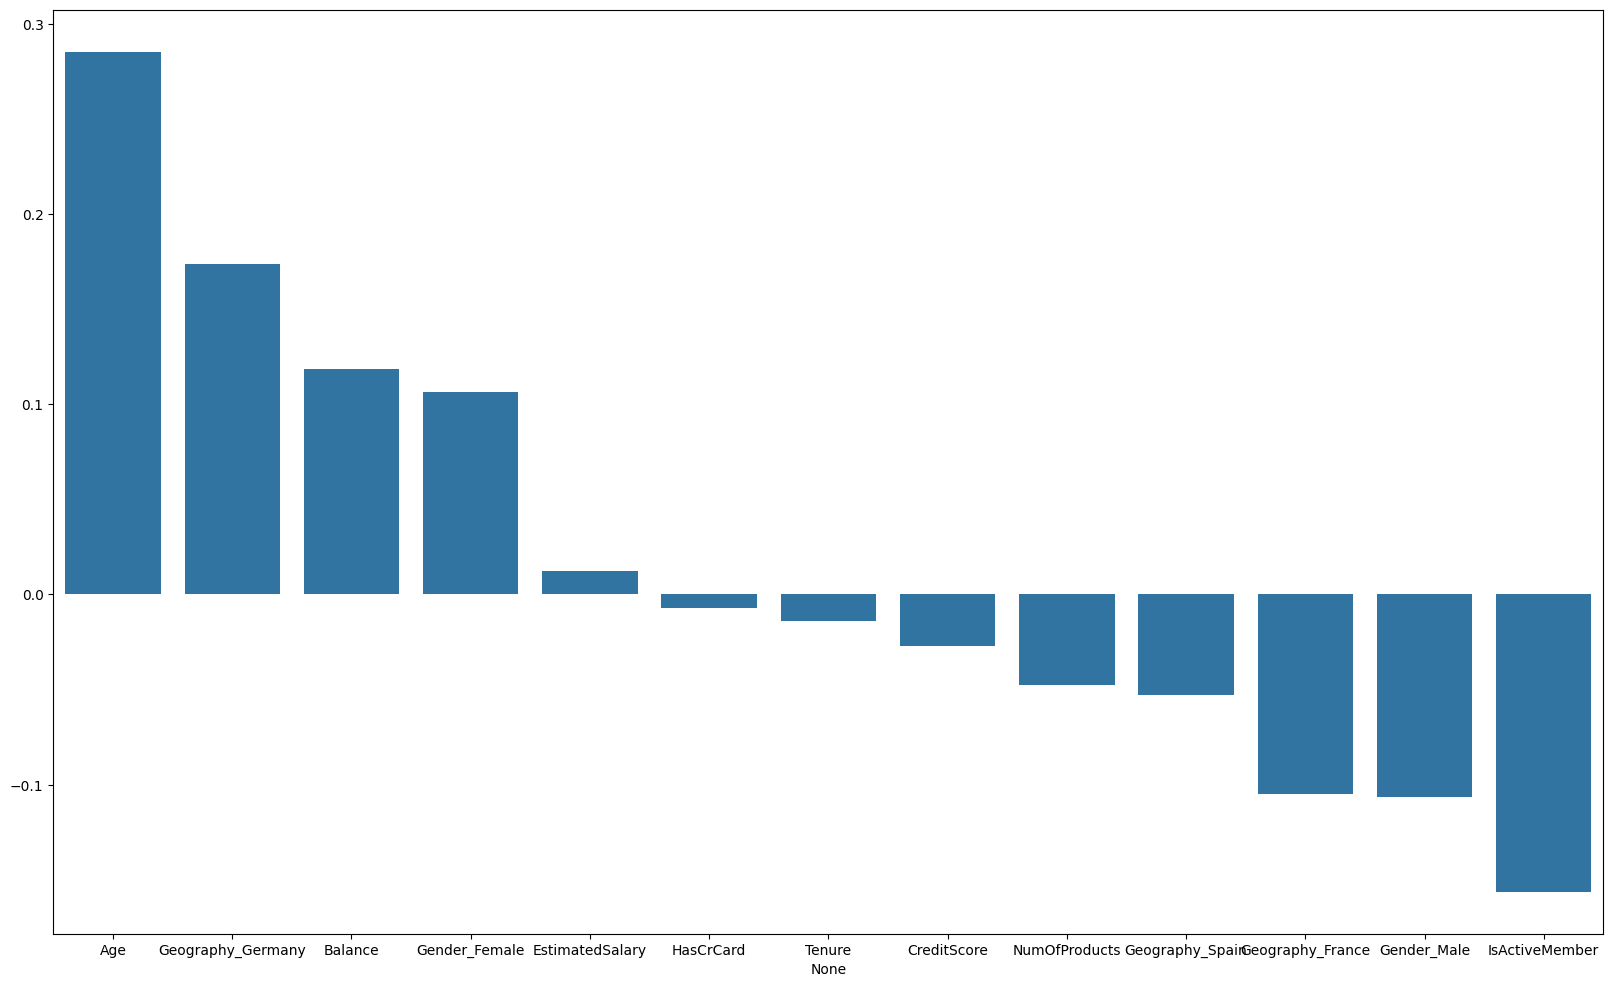

In [74]:
plt.figure(figsize=(20,12))
sns.barplot(x=features.index, y=features.values)
plt.show()

In [75]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Exited
0    7963
1    2037
Name: count, dtype: int64


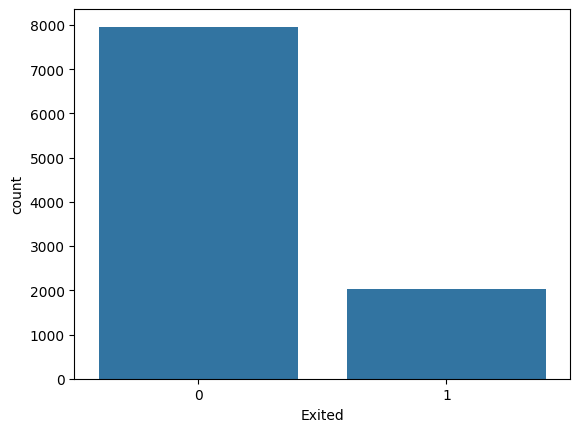

In [76]:
print(df['Exited'].value_counts())

sns.countplot(x='Exited', data=df)
plt.show()

Gender
Male      5457
Female    4543
Name: count, dtype: int64


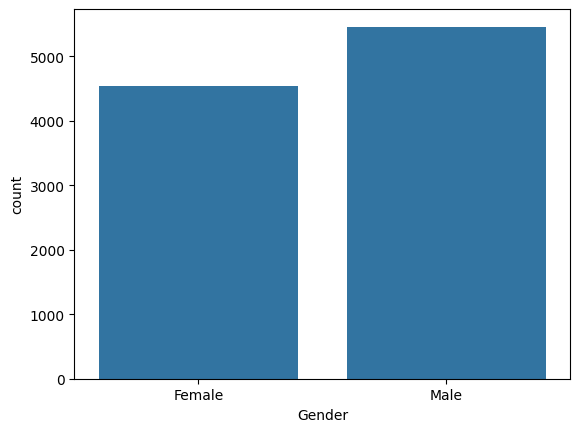

In [77]:
print(df['Gender'].value_counts())

sns.countplot(x='Gender', data=df)
plt.show()

Tenure
2     1048
1     1035
7     1028
8     1025
5     1012
3     1009
4      989
9      984
6      967
10     490
0      413
Name: count, dtype: int64


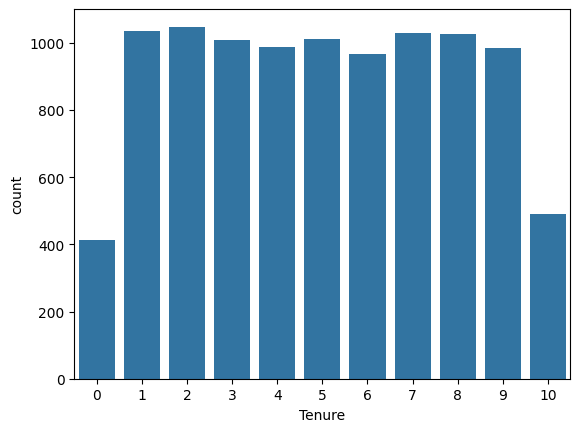

In [78]:
print(df['Tenure'].value_counts())

sns.countplot(x='Tenure', data=df)
plt.show()

NumOfProducts
1    5084
2    4590
3     266
4      60
Name: count, dtype: int64


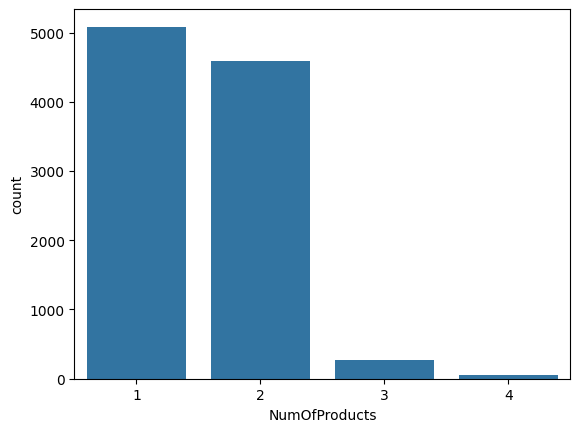

In [79]:
print(df['NumOfProducts'].value_counts())

sns.countplot(x='NumOfProducts', data=df)
plt.show()

HasCrCard
1    7055
0    2945
Name: count, dtype: int64


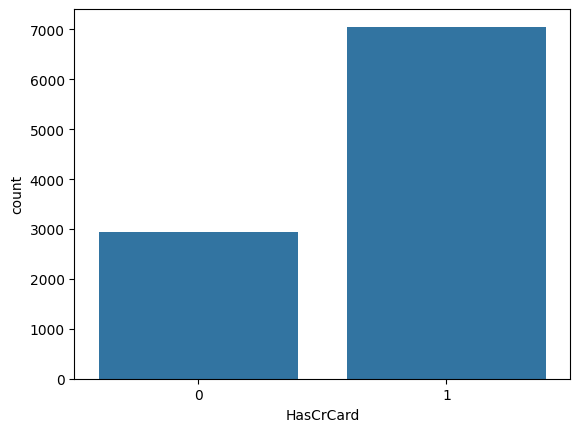

In [80]:
print(df['HasCrCard'].value_counts())

sns.countplot(x='HasCrCard', data=df)
plt.show()

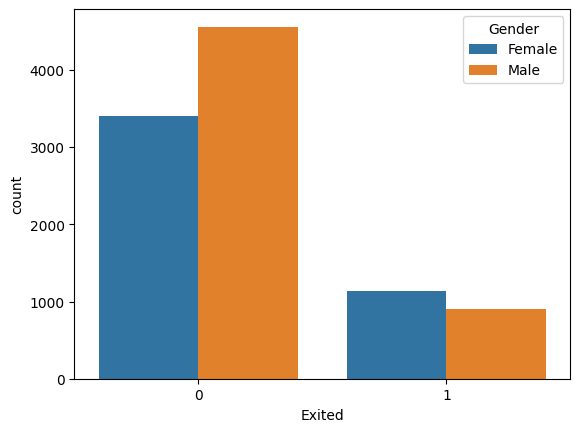

In [81]:
sns.countplot(x='Exited', data= df, hue='Gender')
plt.show()

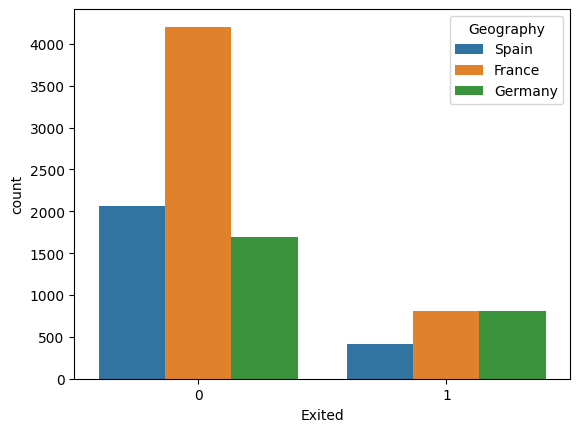

In [82]:
sns.countplot(x='Exited', data= df, hue='Geography')
plt.show()

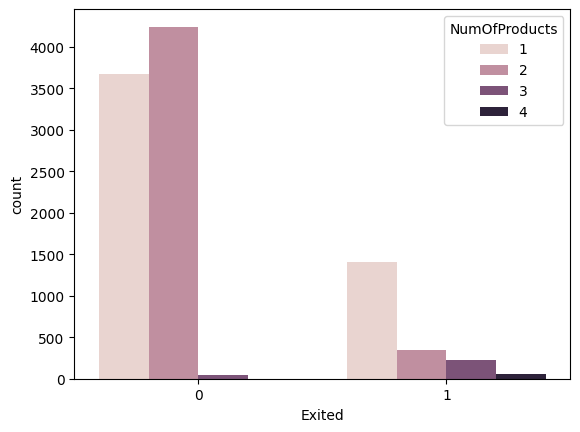

In [83]:
sns.countplot(x='Exited', data= df, hue='NumOfProducts')
plt.show()

d:\Bilal\Udemy\Machine learning essentials\enviroment\.venv\Lib\site-packages\seaborn\distributions.py:2125: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
d:\Bilal\Udemy\Machine learning essentials\enviroment\.venv\Lib\site-packages\seaborn\distributions.py:2125: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)


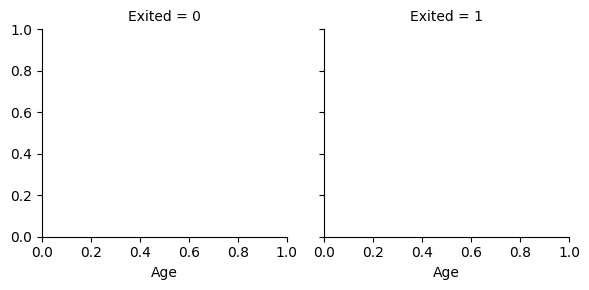

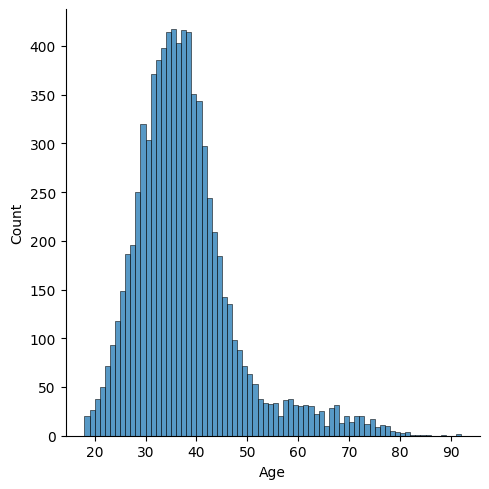

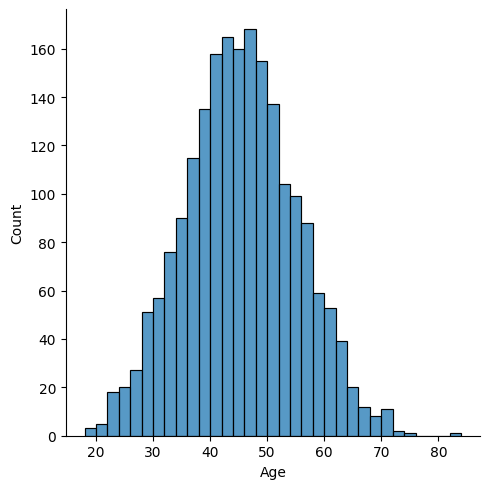

In [84]:
sns.FacetGrid(df, col='Exited')\
    .map(sns.displot, "Age")
plt.show()

In [85]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [86]:
df.drop(columns=['RowNumber', "CustomerId", "Surname"], inplace= True)

In [87]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [88]:
df['Geography']=df['Geography'].astype('category').cat.codes

In [89]:
df['Gender']=np.where(df['Gender']=='Male', 1, 0)

In [90]:
X=df.drop(columns=['Exited']).values
y=df['Exited'].values

In [91]:
X.shape

(10000, 10)

In [92]:
y.shape

(10000,)

### **4. Splitting the Data**
* **Training Set:** Used to teach the model patterns.
* **Testing Set:** Kept hidden to evaluate performance on unseen customers.

In [93]:
from sklearn.model_selection import train_test_split

In [94]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### **5. Model Training (XGBoost)**
We use **XGBoost**, a powerful gradient boosting algorithm.

**Handling Imbalanced Data:**
Since only ~20% of customers churn, a standard model might ignore them to get high accuracy.
* **The Fix:** We use `scale_pos_weight=4`.
* **The Logic:** This tells the model: *"Treat every Churner (1) as 4x more important than a Non-Churner (0)."* This boosts our ability to catch the people leaving.

In [95]:

from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score

In [96]:
basic_model=XGBClassifier()
basic_model.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [97]:
def evaluate_model(model):
    print ("training accuracy:" , model.score(X_train, y_train))
    print ("testing accuracy:" , model.score(X_test, y_test))

    y_pred=model.predict(X_test)

    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("F1 score:", f1_score(y_test, y_pred))

In [98]:
evaluate_model(basic_model)

training accuracy: 0.9644776119402985
testing accuracy: 0.8563636363636363
[[2499  158]
 [ 316  327]]
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      2657
           1       0.67      0.51      0.58       643

    accuracy                           0.86      3300
   macro avg       0.78      0.72      0.75      3300
weighted avg       0.85      0.86      0.85      3300

F1 score: 0.5797872340425532


In [99]:
from sklearn.model_selection import GridSearchCV

In [101]:
xgb_params={
    'n_estimators':[100,200],
    'max_depth' :[4,5]
}

In [ ]:
grid= GridSearchCV(XGBClassifier(), param_grid=xgb_params, scoring='accuracy',cv=10 )
grid.fit(X_train, y_train)

,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'n_estimators': [100, 200, ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [ ]:
print("Best score", grid.best_score_)

In [ ]:
print("Best score", grid.best_params_)

Best score {'n_estimators': 100}


In [ ]:
# The "Imbalanced Data" Fix
# scale_pos_weight=4 tells the model that Churners (1) are 4x more important
model_1 = XGBClassifier(max_depth=4, scale_pos_weight=4)

model_1.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

### **6. Evaluation**
We look beyond Accuracy.
* **Precision:** When we predict Churn, are we right?
* **Recall:** Out of all actual Churners, how many did we find? (This is the most important metric for retention).

In [ ]:
evaluate_model(model_1)

training accuracy: 0.9056716417910448
testing accuracy: 0.8681818181818182
[[2544  113]
 [ 322  321]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      2657
           1       0.74      0.50      0.60       643

    accuracy                           0.87      3300
   macro avg       0.81      0.73      0.76      3300
weighted avg       0.86      0.87      0.86      3300

F1 score: 0.596100278551532


In [ ]:
350+85
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
model_2= GradientBoostingClassifier(n_estimators=500)
model_2.fit(X_train, y_train)

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,500
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


### **7. Business Insights (Feature Importance)**
The model predicts *who* will leave. This chart tells us *why*.
* **Top Features:** These are the levers the bank can pull to reduce churn. 
* *Example:* If "NumOfProducts" is high, perhaps customers with too many accounts feel overwhelmed?

In [ ]:
evaluate_model(model_2)

training accuracy: 0.9073134328358209
testing accuracy: 0.8693939393939394
[[2546  111]
 [ 320  323]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      2657
           1       0.74      0.50      0.60       643

    accuracy                           0.87      3300
   macro avg       0.82      0.73      0.76      3300
weighted avg       0.86      0.87      0.86      3300

F1 score: 0.5998142989786444


### **Conclusion & Recommendation**
The XGBoost model effectively identifies customers at risk of churning.
* **Key Driver:** Age and Number of Products are the strongest predictors.
* **Actionable Insight:** The bank should target older customers with specific retention campaigns and investigate why customers with 3+ products are leaving.